In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def smape(true, pred):
    return 2 * np.mean(np.abs(pred - true) / (np.abs(true) + np.abs(pred)))


In [4]:
df = pd.read_parquet('train.parquet')

In [5]:
df

,item_id,vals_id,epoch,value
0,0,0,2014-01-01 00:00:00,3.237531
1,0,1,2014-01-01 00:18:57,1.835517
2,0,2,2014-01-01 00:37:54,0.751695
3,0,3,2014-01-01 00:56:51,0.077846
4,0,4,2014-01-01 01:15:48,-0.161371
...,...,...,...,...
3115729,3599,1199,2014-01-24 21:31:18,6.192790
3115730,3599,1200,2014-01-24 22:00:00,5.020839
3115731,3599,1201,2014-01-24 22:28:42,3.428408
3115732,3599,1202,2014-01-24 22:57:24,1.839132


In [6]:
def plot_series(df, number):
    testdf = df.loc[(df['item_id'] == number)]
    testdf = testdf.set_index('epoch')
    plt.plot(testdf['value'])
    plt.xticks(rotation='vertical')
    plt.show()

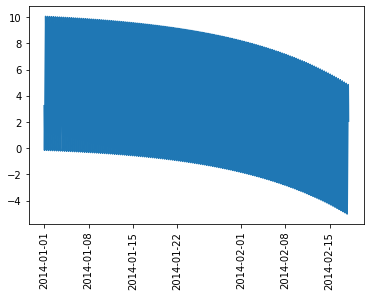

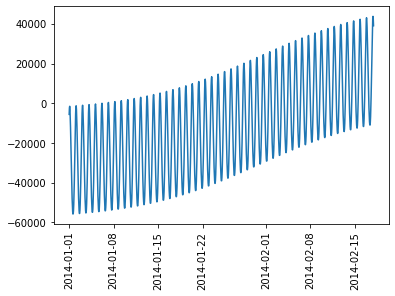

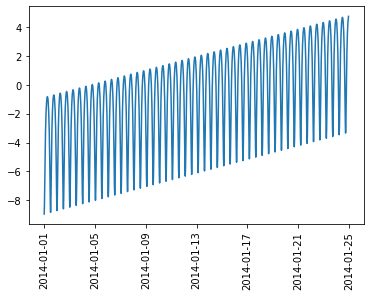

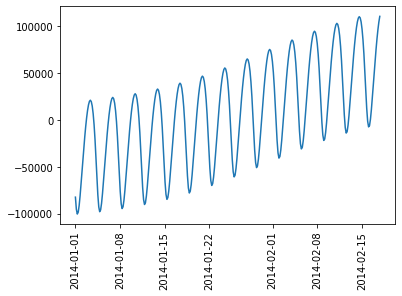

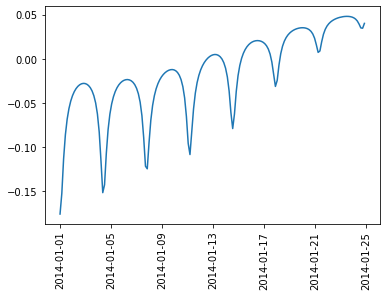

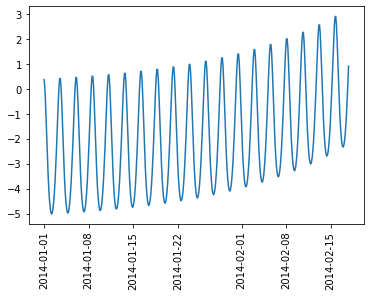

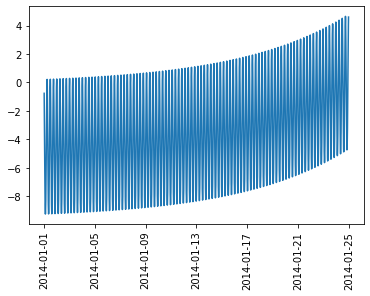

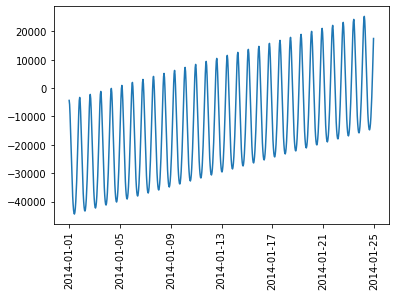

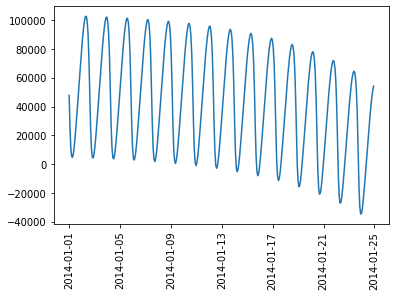

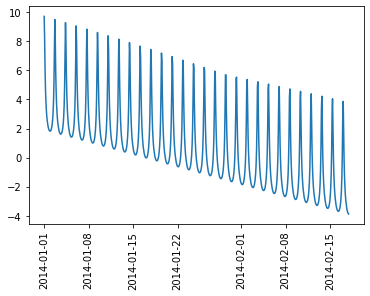

In [7]:
for i in range(10):
    plot_series(df, i)

# Exponential smoothing additive seasonal

In [8]:
#function to get optimal season with cross validation 
def get_optimal_season(series):
    train_size = round(len(series)*0.7) 
    train2 = series[:train_size]
    test2 = series[train_size:]
    season = {}
    for i in range(2, 30):
        try:
            model = ExponentialSmoothing(train2, trend="add", seasonal="add", seasonal_periods=i)
            fit = model.fit()
            pred = fit.forecast(train_size)

            season[i] = smape(test2.values, pred.values)
        except (ValueError, ZeroDivisionError) as e:
            break
    return min(season, key=season.get)

In [11]:
dic = {}
for i in tqdm(range(10)):
    s1 =  df.loc[(df['item_id'] == i)]
    s1 = s1.set_index('epoch')
    s1 = s1.drop(columns = ['item_id', 'vals_id'])
    train_size = round(len(s1)*0.7)  
    train = s1[:train_size]
    test = s1[train_size:]
    opt_season = get_optimal_season(train)
    # train Holt_Winters
    
    model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=opt_season)
    fit = model.fit()
    pred = fit.forecast(len(test))
    
    dic[i] = smape(test.values, pred.values)

  0%|          | 0/10 [00:00<?, ?it/s]/home/victor/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 1137S will be used.
  self._init_dates(dates, freq)
 10%|█         | 1/10 [00:00<00:03,  2.99it/s]/home/victor/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3658S will be used.
  self._init_dates(dates, freq)
 20%|██        | 2/10 [00:00<00:01,  4.70it/s]/home/victor/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 1818S will be used.
  self._init_dates(dates, freq)
 30%|███       | 3/10 [00:00<00:01,  5.54it/s]/home/victor/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 12674S w

In [12]:
#key metric mean
np.mean(list(dic.values()))

1.192513328423398

In [180]:
#searching for constant optimal season without function
opt_s = {}
for j in tqdm(range(2,30)): 
    dic = {}
    for i in range(100):
        s1 =  df.loc[(df['item_id'] == i)]
        s1 = s1.set_index('epoch')
        s1 = s1.drop(columns = ['item_id', 'vals_id'])
        train_size = round(len(s1)*0.7)  
        train = s1[:train_size]
        test = s1[train_size:]
        #opt_season = get_optimal_season(train)
        # train autoregression
        model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=j,
                                         initialization_method="estimated",damped_trend=True)
        fit = model.fit()
        pred = fit.forecast(len(test))

        dic[i] = smape(test.values, pred.values)
    opt_s[j] = np.mean(list(dic.values()))


100%|██████████| 28/28 [05:44<00:00, 12.32s/it]


In [181]:
opt_s

{2: 1.5716515411325331,
 3: 1.5776423700417186,
 4: 1.5846136922622733,
 5: 1.5842179632721922,
 6: 1.5900661671364609,
 7: 1.5827867634742163,
 8: 1.5713425511158332,
 9: 1.5702826129212277,
 10: 1.5685904387024812,
 11: 1.590941140809697,
 12: 1.5900479213998124,
 13: 1.5876064940502244,
 14: 1.5847750062402932,
 15: 1.5983765932216218,
 16: 1.5906922546386386,
 17: 1.5939615365352742,
 18: 1.599232241166809,
 19: 1.5731935564607078,
 20: 1.5763690924424134,
 21: 1.5756477145754264,
 22: 1.5866592451055592,
 23: 1.5583158595839088,
 24: 1.2199336106469503,
 25: 1.558241891743537,
 26: 1.5749841746869284,
 27: 1.596972211808004,
 28: 1.5780008425420584,
 29: 1.5569463659150407}

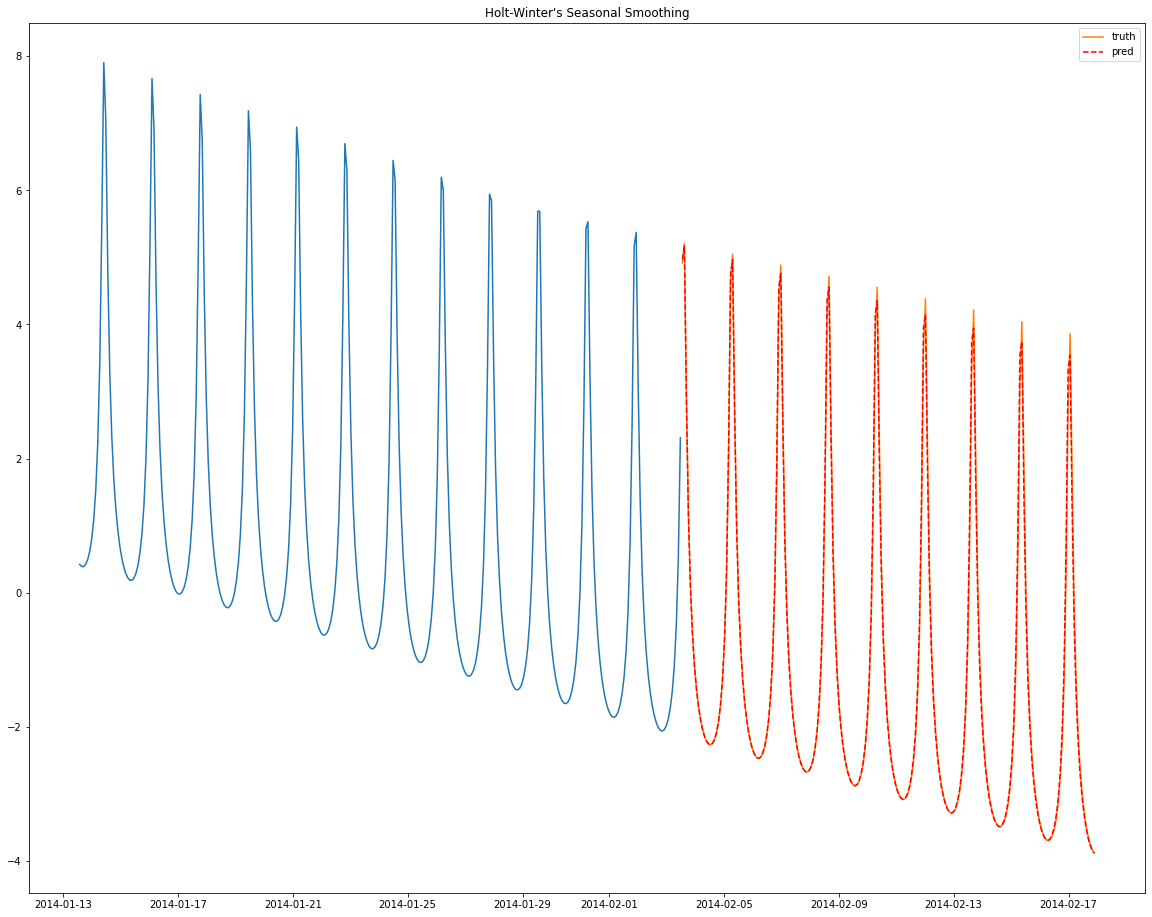

In [13]:
fig, ax = plt.subplots(figsize=(20, 16))
ax.plot(train.index[-300:], train.values[-300:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='red', label = 'pred');
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

# autoarima

In [15]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=False)
    return automodel

In [16]:
dic = {}
for i in tqdm(range(20)):
    s1 =  df.loc[(df['item_id'] == i)]
    s1 = s1.set_index('epoch')
    s1 = s1.drop(columns = ['item_id', 'vals_id'])
    train_size = round(len(s1)*0.7)  
    train = s1[:train_size]
    test = s1[train_size:]
    opt_season = get_optimal_season(train)
    # train autoarima
    
    model = arimamodel(train)
    fc = model.predict(n_periods = len(train))
    
    dic[i] = smape(test.values, fc)


100%|██████████| 20/20 [02:38<00:00,  7.93s/it]


In [17]:
#key metric mean
np.mean(list(dic.values()))

1.3763108435580123

# SARIMAX

In [18]:
import statsmodels.api as sm

In [19]:
model=sm.tsa.statespace.SARIMAX(train['value'],seasonal_order=(1,0,2,16))
results=model.fit()

In [34]:
s1 =  df.loc[(df['item_id'] == 2)]
s1 = s1.set_index('epoch')
s1 = s1.drop(columns = ['item_id', 'vals_id'])
train = s1[:-200]
test = s1[-200:]
dic = {}
for i in range(3):
    for j in range(3):
        for k in tqdm(range(3)):
            model=sm.tsa.statespace.SARIMAX(train['value'],seasonal_order=(i,j,k,24))
            results=model.fit()
            pred = results.predict(start=len(train),end=len(train) + len(test) - 1,dynamic=True).values
            smap = smape(test.values, pred)
            dic[(i,j,k,24)] = smap

  0%|          | 0/3 [00:31<?, ?it/s]


LinAlgError: LU decomposition error.

In [35]:
dic

{(0, 0, 0, 24): 1.9167208633272603,
 (0, 0, 1, 24): 1.8628587783312207,
 (0, 0, 2, 24): 1.8173317273689205,
 (0, 1, 0, 24): 1.1251149302705952,
 (0, 1, 1, 24): 1.1251149302705952,
 (0, 1, 2, 24): 1.1251149302452312,
 (0, 2, 0, 24): 1.1246553826309806,
 (0, 2, 1, 24): 1.1246531721993118,
 (0, 2, 2, 24): 1.1246553826309806,
 (1, 0, 0, 24): 1.1265507760492495,
 (1, 0, 1, 24): 1.1264665657961155,
 (1, 0, 2, 24): 1.1254172408480818,
 (1, 1, 0, 24): 1.1251149302705952,
 (1, 1, 1, 24): 1.1251242869170888,
 (1, 1, 2, 24): 1.1251149302696977,
 (1, 2, 0, 24): 1.1246298320556565,
 (1, 2, 1, 24): 1.1246354143367159,
 (1, 2, 2, 24): 1.4530022509440668}

1.1246531721993118


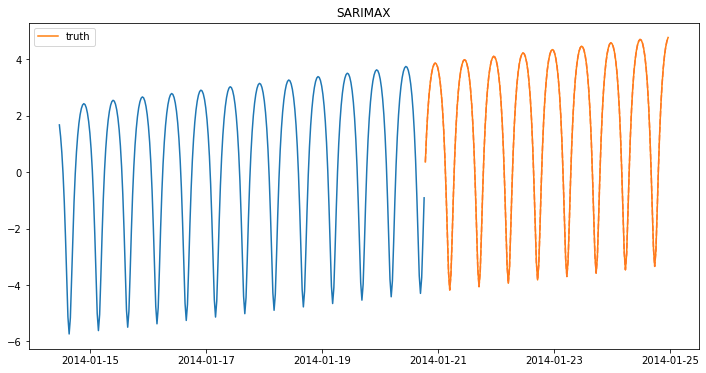

In [36]:


model=sm.tsa.statespace.SARIMAX(train['value'],seasonal_order=(0,2,1,24))
results = model.fit()
pred = results.predict(start=len(train),end=len(train)+len(test)-1,dynamic=True).values
print(smape(test.values, pred))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[-300:], train.values[-300:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823');
ax.legend();
ax.set_title("SARIMAX");

In [53]:
dic = {}
for i in tqdm(range(20)):
    s1 =  df.loc[(df['item_id'] == i)]
    s1 = s1.set_index('epoch')
    s1 = s1.drop(columns = ['item_id', 'vals_id'])
    train_size = round(len(s1)*0.7)  
    train = s1[:train_size]
    test = s1[train_size:]
    # train SARIMAX
    
    model=sm.tsa.statespace.SARIMAX(train['value'],seasonal_order=(0,2,1,24))
    results = model.fit()
    pred = results.predict(start=len(train),end=len(train)+len(test)-1,dynamic=True).values
    
    dic[i] = smape(test.values, pred)

100%|██████████| 20/20 [04:29<00:00, 13.49s/it]


In [54]:
#key metric mean
np.mean(list(dic.values()))

1.1791064438179986

# autoregression

In [40]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

In [100]:
#searching opt lag with cross validation
def get_optimal_lags(series):
    train_size = round(len(series)*0.8) 
    train2 = series[:train_size]
    test2 = series[train_size:]
    lags = {}
    for i in range(20, 26):
        try:
            model = AutoReg(train2, lags=i)
            model_fit = model.fit()
            #print('Coefficients: %s' % model_fit.params)
            predictions = model_fit.predict(start=len(train2), end=len(train2)+len(test2)-1, dynamic=True)

            lags[i] = mean_squared_error(predictions.values, test2.values)
        except (ValueError, ZeroDivisionError) as e:
            break
    return min(lags, key=lags.get)

In [56]:
#searching optimal lag worked worse than constant lag
#so now we try to find optimal lag around 24
opt_s = {}
for j in tqdm([5, 23, 24, 25, 27]):
    dic = {}
    for i in range(1000):
        s1 =  df.loc[(df['item_id'] == i)]
        s1 = s1.set_index('epoch')
        s1 = s1.drop(columns = ['item_id', 'vals_id'])
        train_size = round(len(s1)*0.8)  
        train = s1[:train_size]
        test = s1[train_size:]
        #opt_lag = get_optimal_lags(train)
        # train autoregression
        try:
            model = AutoReg(train, lags=24, seasonal = True, period = j)
        except ValueError:
            model = AutoReg(train, lags=24)
        model_fit = model.fit()
        #print('Coefficients: %s' % model_fit.params)
        predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

        dic[i] = smape(predictions.values, test.values)
    opt_s[j] = np.mean(list(dic.values()))


100%|██████████| 4/4 [02:30<00:00, 37.54s/it]


In [57]:
opt_s 

{5: 1.215188309541239,
 23: 1.2149109818048702,
 25: 1.2153744665441044,
 27: 1.2154639637429805}

Next i will try to search for optimal trend pattern with autoregression 24 lag

In [46]:
dic = {}
#opt_lags = {}
for i in tqdm(range(20)):
    s1 =  df.loc[(df['item_id'] == i)]
    s1 = s1.set_index('epoch')
    s1 = s1.drop(columns = ['item_id', 'vals_id'])
    train_size = round(len(s1)*0.7)  
    train = s1[:train_size]
    test = s1[train_size:]
   # opt_lag = get_optimal_lags(train)
    # train autoregression
    model = AutoReg(train, lags=24, trend='c')
    model_fit = model.fit()
    #print('Coefficients: %s' % model_fit.params)
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
    
    dic[i] = smape(predictions.values, test.values)
    #opt_lags[i] = opt_lag

100%|██████████| 20/20 [00:00<00:00, 40.98it/s]


In [47]:
np.mean(list(dic.values())) 

1.190325856742744

In [45]:
dic = {}
opt_lags = {}
for i in tqdm(range(20)):
    s1 =  df.loc[(df['item_id'] == i)]
    s1 = s1.set_index('epoch')
    s1 = s1.drop(columns = ['item_id', 'vals_id'])
    train_size = round(len(s1)*0.7)  
    train = s1[:train_size]
    test = s1[train_size:]
   # opt_lag = get_optimal_lags(train)
    # train autoregression
    model = AutoReg(train, lags=24, trend='ct')
    model_fit = model.fit()
    #print('Coefficients: %s' % model_fit.params)
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
    
    dic[i] = smape(predictions.values, test.values)
    #opt_lags[i] = opt_lag
np.mean(list(dic.values())) #opt_lag

100%|██████████| 20/20 [00:00<00:00, 42.07it/s]


1.1879313364395832

In [48]:
s1 =  df.loc[(df['item_id'] == 0)]
s1 = s1.set_index('epoch')
s1 = s1.drop(columns = ['item_id', 'vals_id'])
train_size = round(len(s1)*0.7)  
train = s1[:train_size]
test = s1[train_size:]
# train autoregression
model = AutoReg(train, lags=24, trend='ct')
model_fit = model.fit()
#print('Coefficients: %s' % model_fit.params)
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

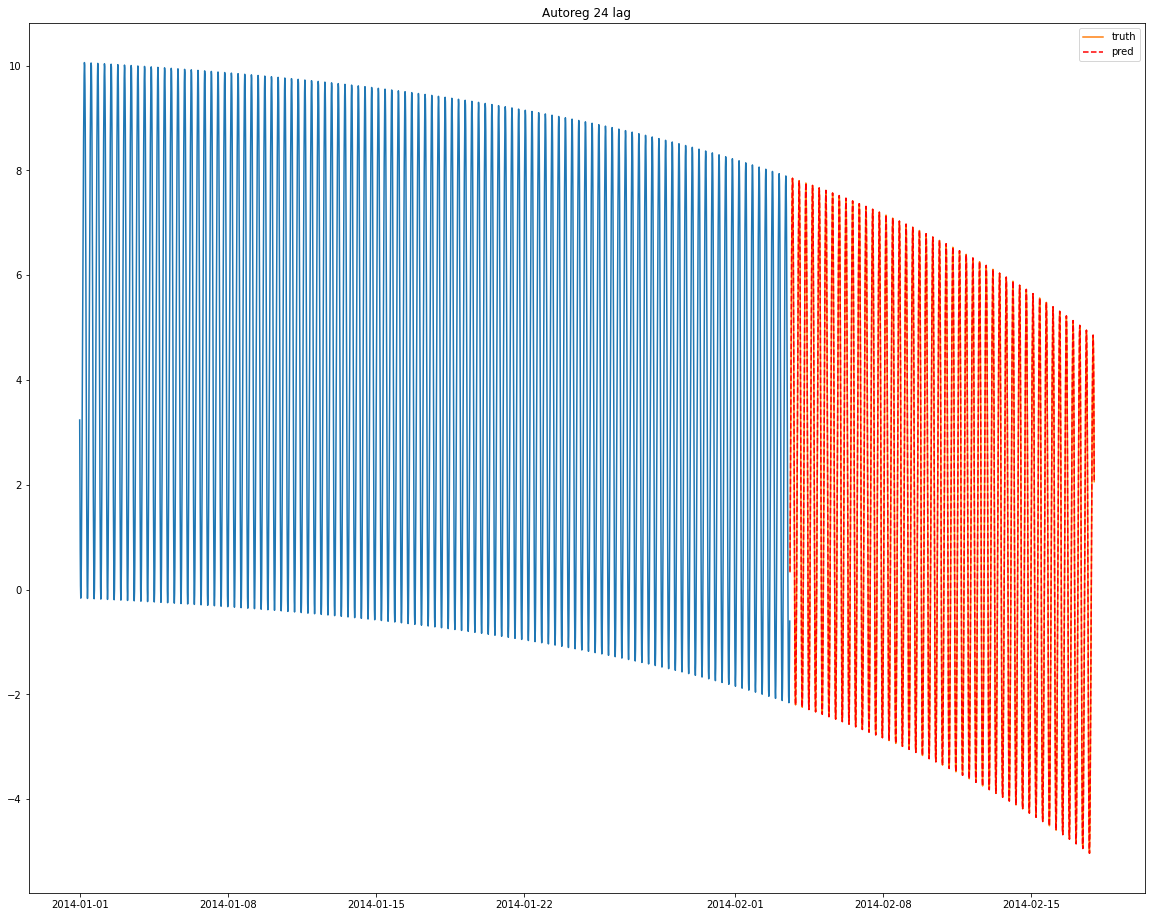

In [49]:
fig, ax = plt.subplots(figsize=(20, 16))
ax.plot(train.index, train.values);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, predictions.values, linestyle='--', color='red', label = 'pred');
ax.legend();
ax.set_title("Autoreg 24 lag");

# submissions

In [22]:
df1 = pd.read_csv('submission_sample.csv')

In [23]:
df1

,row,value
0,0_3646,0.202660
1,0_3647,0.671267
2,0_3648,0.675564
3,0_3649,0.179560
4,0_3650,0.615844
...,...,...
780757,3599_1500,0.984763
780758,3599_1501,0.036468
780759,3599_1502,0.880326
780760,3599_1503,0.365844


# test df

In [50]:
df2 = pd.read_parquet('test.parquet')

In [51]:
df2

,item_id,vals_id,epoch
0,0,3646,2014-02-17 23:31:42
1,0,3647,2014-02-17 23:50:39
2,0,3648,2014-02-18 00:09:36
3,0,3649,2014-02-18 00:28:33
4,0,3650,2014-02-18 00:47:30
...,...,...,...
780757,3599,1500,2014-01-30 21:30:00
780758,3599,1501,2014-01-30 21:58:42
780759,3599,1502,2014-01-30 22:27:24
780760,3599,1503,2014-01-30 22:56:06


In [52]:
#creating results dataframe
result = pd.DataFrame()
N=len(df2['item_id'].unique())
for i in range(N):
    item = df2.loc[(df2['item_id'] == i)]['item_id']
    vals = df2.loc[(df2['item_id'] == i)]['vals_id']
    a = pd.DataFrame(item.astype(str) + '_' + vals.astype(str))
    result = result.append(a)

In [106]:
result.to_csv('result_df.csv')

In [108]:
#predictions with autoreg 24 lag constant-time trend
test_predictions = []
N = len(df2['item_id'].unique())
for i in tqdm(range(N)):
    #train
    s1 =  df.loc[(df['item_id'] == i)]
    s1 = s1.set_index('epoch')
    s1 = s1.drop(columns = ['item_id', 'vals_id'])
    
    #Test 
    test = df2.loc[(df2['item_id'] == i)]
    test = test.set_index('epoch')
    test = test.drop(columns = ['item_id', 'vals_id'])
    
    # train autoregression
    #opt_lag = get_optimal_lags(s1)
    model = AutoReg(s1, lags = 24, trend='ct')
    model_fit = model.fit()
    
    #predictions
    predictions = model_fit.predict(start=len(s1), end=len(s1)+len(test)-1, dynamic=True)
    
    test_predictions = test_predictions + list(predictions.values)

100%|██████████| 3600/3600 [02:37<00:00, 22.92it/s]


In [109]:
#!pip install pickle
import pickle

file_name = "predictions_autoreg_24_trend_ct.pkl"

open_file = open(file_name, "wb")
pickle.dump(test_predictions, open_file)
open_file.close()

In [110]:
result['value'] = test_predictions
result.columns = ['row', 'value']
result.set_index('row').to_csv('AR_24_trend_ct.csv')

In [30]:
result

,row,value
0,0_3646,0.597014
1,0_3647,-0.959167
2,0_3648,-2.434550
3,0_3649,-3.669436
4,0_3650,-4.552202
...,...,...
780757,3599_1500,1.567079
780758,3599_1501,2.119736
780759,3599_1502,2.738388
780760,3599_1503,3.422208
